# Project 5 - Diet Tracker
Author - Andy Tan

This is the main notebook for creating a food image classifier using neural networks using the Food-11 food image dataset. Additional information on the dataset and data preparation can be found in the project_05_data.ipynb notebook. This notebook was designed to be run on Google Colab to take advantage of GPU processing.

Table of Contents:
1. Import packages
2. Read data
3. Model Building
4. Model Assessment

## 1. Import Packages

In [3]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import keras
from keras.applications import mobilenet_v2, inception_v3, resnet_v2
from keras.backend import clear_session
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout
from keras.optimizers import SGD, Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 2. Read the Data
The following two blocks of code are used to connect colab to google drive to read in data. They need to be run once per session. Uncomment to run.


In [0]:
# Mount Google Drive where Food-11 dataset is saved as zip file.

#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
# Extracting images from Food-11 zip

#!unzip "/content/drive/My Drive/Colab Notebooks/data/food-11.zip"

In [0]:
#Reading in dataframes to be used in flow_from_dataframe() generators
df_train = pd.read_pickle(f'/content/drive/My Drive/Colab Notebooks/data/food11_train.pkl')
df_val = pd.read_pickle(f'/content/drive/My Drive/Colab Notebooks/data/food11_val.pkl')
df_test = pd.read_pickle(f'/content/drive/My Drive/Colab Notebooks/data/food11_test.pkl')

In [9]:
df_train

,path,folder,name,cat,cat_name,cat2_name,is_meat
0,training/3_462.jpg,training,3_462.jpg,3,egg,dairy-egg,not_meat
1,training/4_69.jpg,training,4_69.jpg,4,fried,fried,not_meat
2,training/5_925.jpg,training,5_925.jpg,5,meat,meat,meat
3,training/1_202.jpg,training,1_202.jpg,1,dairy,dairy-egg,not_meat
4,training/5_241.jpg,training,5_241.jpg,5,meat,meat,meat
...,...,...,...,...,...,...,...
9861,training/8_367.jpg,training,8_367.jpg,8,seafood,seafood,not_meat
9862,training/10_627.jpg,training,10_627.jpg,10,fruit-veg,fruit-veg,not_meat
9863,training/2_751.jpg,training,2_751.jpg,2,dessert,dessert,not_meat
9864,training/9_1229.jpg,training,9_1229.jpg,9,soup,soup,not_meat


## 3. Model Building
To make an image classifier, a convolutional neural network was built using transfer learning and then fine-tuning from InceptionV3. InceptionV3, also known as GoogleNet, is a pretrained CNN using the Imagenet database. It was developed to achieve higher accuracy without a significant increase in computing cost and was chosen in this project for those reasons.

The following resources were used to help design the CNN in this project:<br>
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html<br>
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb<br>
https://colab.research.google.com/drive/1xL2jSdY-MGlN60gGuSH_L30P7kxxwUfM

### 3.1 Data Preprocessing
Data was loaded into Keras using ImageDataGenerator and flow_from_dataframe methods. Data augmentation was used to increase size of training data.

In [10]:
img_size = 299  #image size for inceptionv3

#Training image generator with image augmentation
datagen = ImageDataGenerator(
    preprocessing_function=inception_v3.preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2])

#Augmentation is not used for validation and test data. Data is normalized using built it inception_v3 preprocessing function
val_datagen = ImageDataGenerator(preprocessing_function=inception_v3.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=inception_v3.preprocess_input)

'''Setting classification scheme:
    'is_meat' is a binary classifier. 
    'cat_name' classifies into the 11 categories of the original dataset. 
    'cat2_name' consolidates the original categories into 8 categories.'''
target = 'cat2_name'   # 'is_meat', 'cat_name'

num_classes = df_train[target].nunique()

# Initializing generators to read images
train_generator = datagen.flow_from_dataframe(dataframe=df_train, directory='/content/food-11/training',
                                             x_col="name", y_col=target,
                                             target_size=(img_size,img_size),
                                             class_mode="categorical")
val_generator = val_datagen.flow_from_dataframe(dataframe=df_val, directory='/content/food-11/validation',
                                             x_col="name", y_col=target,
                                             target_size=(img_size,img_size),
                                             class_mode="categorical")
test_generator = test_datagen.flow_from_dataframe(dataframe=df_test, directory='/content/food-11/evaluation',
                                             x_col="name", y_col=target,
                                             target_size=(img_size,img_size),
                                             class_mode="categorical",
                                             shuffle=False)

Found 9866 validated image filenames belonging to 8 classes.
Found 3430 validated image filenames belonging to 8 classes.
Found 3347 validated image filenames belonging to 8 classes.


In [11]:
# Class labels
class_labels = train_generator.class_indices.keys()
print(f'Class labels:\n{class_labels}')

Class labels:
dict_keys(['dairy-egg', 'dessert', 'fried', 'fruit-veg', 'grains', 'meat', 'seafood', 'soup'])


In [0]:
# Calculate class weights as inverse of class distribution. These will be used when fitting the model to correct for class imbalance.
counts = Counter(train_generator.classes)

max_num = float(max(counts.values()))       
class_weights = {class_id : max_num/class_num for class_id, class_num in counts.items()}

### 3.2 Transfer Learning
We will first apply transfer learning to InceptionV3 by building a new fully connected block on the convolutional base. The connected block consists of a globalaveragepooling() laying which helped with overfitting compared to Flatten(). Dropout percentage was also increased to help with overfitting.

In [33]:
# Import InceptionV3 model except for top layer
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size,img_size,3))

87916544/87910968 [==============================] - 7s 0us/step


In [0]:
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False
    
# Establish new fully connected block.
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Compile model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Calculate step size for generators
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VAL = val_generator.n//val_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

# Fit model to training image generator.
model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator, validation_steps=STEP_SIZE_VAL,
                    class_weight=class_weights,
                    epochs=10)

Epoch 1/10
415/415 [==============================] - 428s 1s/step - loss: 1.9605 - accuracy: 0.4883 - val_loss: 0.8598 - val_accuracy: 0.7103
Epoch 2/10
415/415 [==============================] - 422s 1s/step - loss: 1.4154 - accuracy: 0.6438 - val_loss: 1.1425 - val_accuracy: 0.6935
Epoch 3/10
415/415 [==============================] - 409s 985ms/step - loss: 1.3305 - accuracy: 0.6631 - val_loss: 0.7555 - val_accuracy: 0.7140
Epoch 4/10
415/415 [==============================] - 404s 974ms/step - loss: 1.2421 - accuracy: 0.6886 - val_loss: 0.4334 - val_accuracy: 0.7469
Epoch 5/10
415/415 [==============================] - 402s 969ms/step - loss: 1.1907 - accuracy: 0.7024 - val_loss: 0.7321 - val_accuracy: 0.7430
Epoch 6/10
415/415 [==============================] - 396s 954ms/step - loss: 1.1544 - accuracy: 0.7116 - val_loss: 0.6045 - val_accuracy: 0.7665
Epoch 7/10
415/415 [==============================] - 395s 953ms/step - loss: 1.1199 - accuracy: 0.7160 - val_loss: 1.1791 - val_a

'\nmodel.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,\n                    validation_data=val_generator, validation_steps=STEP_SIZE_VAL,\n                    class_weight=class_weights,\n                    epochs=10)'

### 3.2 Fine-Tuning
The first round of training was performed for 10 epochs at which point there was minimal gain in validation accuracy. Next we will proceed with fine-tuning of the model by unfreezing more layers in the InceptionV3 base. Per Chollet, it is necessary to do the initial training prior to unfreezing more layers to preserve the representations in these layers.

For fine-tuning, we are unfreezing after the "Mixed8" layer (layer 248). This corresponds to unfreezing the last 2 convolutional sections of the InceptionV3 model. 



In [37]:
# Get layer numbers for InceptionV3 base
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [0]:
# Unfreeze layers after 'Mixed8' layer
for layer in model.layers[:249]:
  layer.trainable = False
for layer in model.layers[249:]:
  layer.trainable = True

In [0]:
# Re-compile model. This time we will use a non-adaptive optimizer with low learning rate to preserve previously learned representations.
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Adding early stopping parameters and a learning rate reducing schedule
callback = [EarlyStopping(monitor='val_loss', verbose=1, patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=5)]

# Fine-tune model on training image generator. Since early stopping parameters are in place, we will set a high number of epochs to run.
history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator, validation_steps=STEP_SIZE_VAL,
                    class_weight=class_weights,
                    callbacks=callback,
                    epochs=100)

Epoch 1/100
415/415 [==============================] - 403s 970ms/step - loss: 0.8690 - accuracy: 0.7844 - val_loss: 0.4482 - val_accuracy: 0.8552
Epoch 2/100
415/415 [==============================] - 400s 963ms/step - loss: 0.6215 - accuracy: 0.8446 - val_loss: 0.6473 - val_accuracy: 0.8621
Epoch 3/100
415/415 [==============================] - 405s 977ms/step - loss: 0.4888 - accuracy: 0.8808 - val_loss: 0.5826 - val_accuracy: 0.8869
Epoch 4/100
415/415 [==============================] - 403s 970ms/step - loss: 0.4118 - accuracy: 0.8979 - val_loss: 0.1025 - val_accuracy: 0.8926
Epoch 5/100
415/415 [==============================] - 400s 964ms/step - loss: 0.3434 - accuracy: 0.9126 - val_loss: 0.2745 - val_accuracy: 0.8869
Epoch 6/100
415/415 [==============================] - 401s 965ms/step - loss: 0.2952 - accuracy: 0.9300 - val_loss: 0.2062 - val_accuracy: 0.8893
Epoch 7/100
415/415 [==============================] - 399s 961ms/step - loss: 0.2543 - accuracy: 0.9369 - val_loss: 0

In [0]:
# Plotting accuracy and validation during training epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(7,7))
sns.lineplot(epochs, acc, label='Training')
sns.lineplot(epochs, val_acc, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xtitle('Epochs')
plt.ytitle('Accuracy')
plt.legend()

plt.figure(figsize=(7,7))
sns.lineplot(epochs, loss, label='Training')
sns.lineplot(epochs, val_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xtitle('Epochs')
plt.ytitle('Loss')
plt.legend()

plt.show()

In [0]:
# Save model
model.save('/content/drive/My Drive/Colab Notebooks/data/model_cat2')

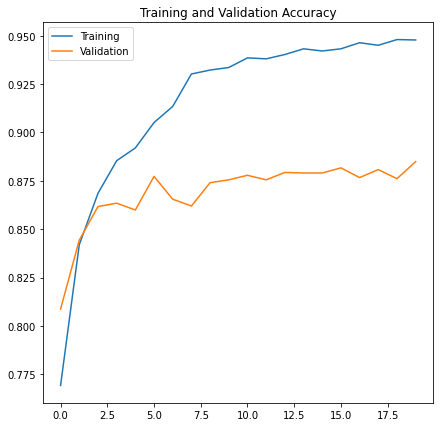

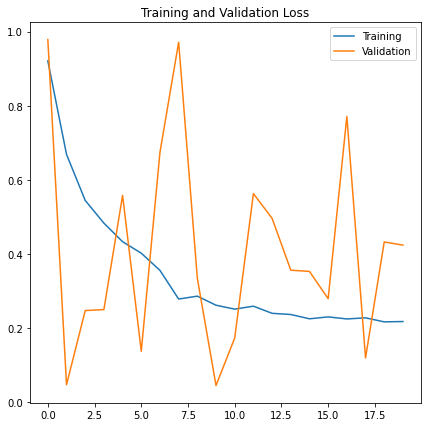

## 4. Model Assessment
Assess performance of model on reserved test dataset

In [0]:
# Evaluate model on test image generator
print('Performance on test data:')
print(f'{model.metrics_names[0]}: model.evaluate_generator(test_generator)[0]')
print(f'{model.metrics_names[1]}: model.evaluate_generator(test_generator)[1]')

In [0]:
# Get predicted classes
preds = model.predict_generator(test_generator, STEP_SIZE_TEST+1)
preds = np.argmax(preds, axis=1)



In [14]:
# Get per-class Metrics
print('Classification Report\n')
print(classification_report(test_generator.classes, preds))

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       483
           1       0.89      0.82      0.85       500
           2       0.80      0.95      0.87       287
           3       0.96      0.94      0.95       231
           4       0.93      0.88      0.91       611
           5       0.90      0.88      0.89       432
           6       0.93      0.81      0.87       303
           7       0.99      0.94      0.97       500

    accuracy                           0.89      3347
   macro avg       0.90      0.90      0.89      3347
weighted avg       0.90      0.89      0.89      3347



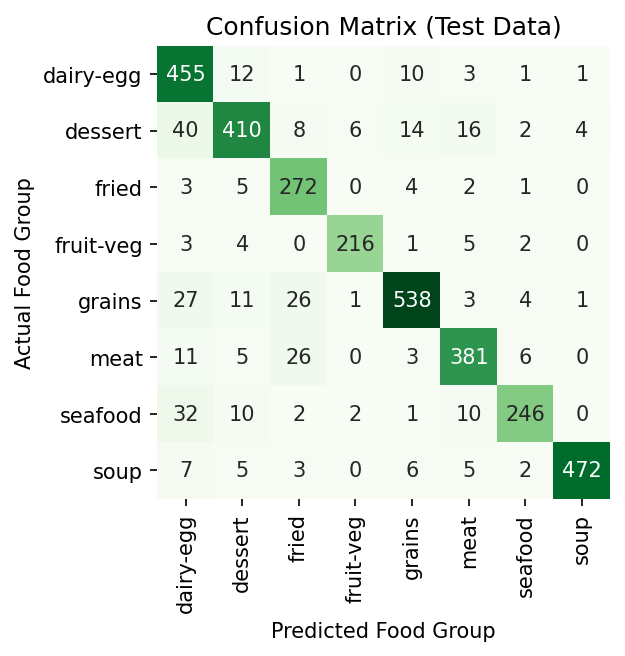

In [18]:
# Confusion matrix for test set
confusion = confusion_matrix(test_generator.classes,preds)
plt.figure(dpi=150)
sns.heatmap(confusion, cmap=plt.cm.Greens, annot=True, square=True, fmt='d', cbar=False, xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())

plt.xlabel('Predicted Food Group')
plt.ylabel('Actual Food Group')
plt.title('Confusion Matrix (Test Data)');

## 5. Production model
In this section, we are creating a "production model" that can be used on new images outside of the dataset. The model is retrained by adding the validation data into the training set. The previously set aside test data will be used for validation during training. The purpose of this is to create a slightly more robust model by using more images for training.

In [0]:
# Clear previous model
clear_session()

In [17]:
# Read dataframe containing training and validation data
df_all = pd.read_pickle(f'/content/drive/My Drive/Colab Notebooks/data/food11_all.pkl')

# Create image generator
all_generator = datagen.flow_from_dataframe(dataframe=df_all, directory='/content/food-11/',
                                             x_col="path", y_col=target,
                                             target_size=(img_size,img_size),
                                             class_mode="categorical")


Found 13296 validated image filenames belonging to 8 classes.


In [0]:
# Copy base model
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size,img_size,3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Establish new fully connected block.
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Compile model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Calculate step size for generators
STEP_SIZE_ALL = all_generator.n//all_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

# Fit model to training image generator.
model.fit_generator(generator=all_generator, steps_per_epoch=STEP_SIZE_ALL,
                    validation_data=test_generator, validation_steps=STEP_SIZE_TEST,
                    class_weight=class_weights,
                    epochs=10)

Epoch 1/10
415/415 [==============================] - 384s 926ms/step - loss: 1.9943 - accuracy: 0.4696 - val_loss: 0.9358 - val_accuracy: 0.6578
Epoch 2/10
415/415 [==============================] - 379s 912ms/step - loss: 1.4273 - accuracy: 0.6371 - val_loss: 1.0668 - val_accuracy: 0.7273
Epoch 3/10
415/415 [==============================] - 375s 904ms/step - loss: 1.3173 - accuracy: 0.6665 - val_loss: 0.7118 - val_accuracy: 0.7454
Epoch 4/10
415/415 [==============================] - 375s 904ms/step - loss: 1.2458 - accuracy: 0.6855 - val_loss: 0.5263 - val_accuracy: 0.7131
Epoch 5/10
415/415 [==============================] - 377s 909ms/step - loss: 1.1810 - accuracy: 0.6999 - val_loss: 0.6893 - val_accuracy: 0.7638
Epoch 6/10
415/415 [==============================] - 377s 907ms/step - loss: 1.1539 - accuracy: 0.7091 - val_loss: 0.4665 - val_accuracy: 0.7710
Epoch 7/10
415/415 [==============================] - 377s 908ms/step - loss: 1.1220 - accuracy: 0.7168 - val_loss: 1.0262 -

In [0]:
# Unfreeze layers after 'Mixed8' layer
for layer in model.layers[:249]:
  layer.trainable = False
for layer in model.layers[249:]:
  layer.trainable = True

# Re-compile model with SGD and low learning rate
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Adding early stopping and learning rate reducing schedule
callback = [EarlyStopping(monitor='val_loss', verbose=1, patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=5)]

# Fine-tune model on training image generator
history = model.fit_generator(generator=all_generator, steps_per_epoch=STEP_SIZE_ALL,
                    validation_data=test_generator, validation_steps=STEP_SIZE_TEST,
                    class_weight=class_weights,
                    callbacks=callback,
                    epochs=100)

Epoch 1/100
415/415 [==============================] - 389s 938ms/step - loss: 0.8563 - accuracy: 0.7881 - val_loss: 0.4571 - val_accuracy: 0.8507
Epoch 2/100
415/415 [==============================] - 382s 920ms/step - loss: 0.6617 - accuracy: 0.8416 - val_loss: 0.6676 - val_accuracy: 0.8884
Epoch 3/100
415/415 [==============================] - 382s 919ms/step - loss: 0.5661 - accuracy: 0.8613 - val_loss: 0.5250 - val_accuracy: 0.8682
Epoch 4/100
415/415 [==============================] - 382s 920ms/step - loss: 0.4856 - accuracy: 0.8831 - val_loss: 0.2193 - val_accuracy: 0.8706
Epoch 5/100
415/415 [==============================] - 381s 919ms/step - loss: 0.3903 - accuracy: 0.9029 - val_loss: 0.2990 - val_accuracy: 0.8923
Epoch 6/100
415/415 [==============================] - 380s 917ms/step - loss: 0.3827 - accuracy: 0.9079 - val_loss: 0.1697 - val_accuracy: 0.8929
Epoch 7/100
415/415 [==============================] - 379s 913ms/step - loss: 0.3239 - accuracy: 0.9206 - val_loss: 0

In [0]:
# Save production model
model.save('/content/drive/My Drive/Colab Notebooks/data/model_prod')